# Embeddings

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logo.png" width=150>

到目前為止，我們已經可以使用 one-hot 編碼的方式來表示一串文字，它是一個 n 維的陣列，每一個維度代表一個單字，而維度的值代表該字在整個句子中出現的次數。這種方式會讓我們失去每個輸入文字的結構性資訊。

```python
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]```
 
 
我們同樣可以將輸入透過 one-hot 編碼的方式進行，每一個詞 (token) 用 n 維陣列表示。
 
 ```python
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
```

這種方法讓我們保存了結構化的資訊，但有兩個主要的缺點。第一，如果我們的字詞數量很龐大時，在計算每一個詞所需要的時間就相當可觀。第二，儘管我們保留了詞的結構化資訊，但每個詞實際上的意義和關係依舊無法表達。

在本篇內容中，我們會透過學習 embedding 的方法來彌補目前學習到的方法的不足之處。

# 概要

* **目標:** 呈現本文中字詞之間的語意關係
* **優點:** 
    * 捕捉字詞間的關係並且保持低維度
    * 可解釋的字詞表示
* **缺點:** 無
* **其他:** 有許多預先訓練好的 embedding 模型可以選擇，但你也可以重新訓練自己的 embedding 模型

# 學習 embeddings

關於 embedding 的最主要概念是把每個字詞透過固定長度的表示法來表示，而不是所有字詞的總數。所以，每一個字詞 (token) 不再是 [1XV]，V 是字詞總數，而是 [1 X D]，D 是 embedding 的大小 (通常我們使用 50、100、200、300 等)。每個表示法中的值不再是 0 或 1，而是在 D 維的潛在空間 (latent space) 中的浮點數。如果 embedding 真的可以捕捉字詞之間的關係，那我們應該可以探查潛在空間 (latent space)，並且確認這個已知的關係 (我們會在後面看到這一點)。

但我們要怎麼學習 embedding 呢？直覺來看，我們是從該字詞的上下文而不是字詞本身來學習其意義，有以下幾種方法：

1. 給定字詞的上下文，預測目標字詞 (CBOW - continuous bag of words)
2. 給定目標詞，預測其上下文的字詞 (skip-gram)
3. 給定連續的字詞，預測下一個字 (LM - language modeling)

所有的這些方法都包含建立資料來訓練我們的模型。在句子中的每一個字詞都會成為目標詞，而其上下文的字詞則透過視窗 (window) 來決定。在下圖中 (skip-gram)，視窗的大小為 2。我們對於語料庫中的所有句子都重複這樣的步驟，這就產生了非監督學習任務的訓練資料。這是一種非監督式學習的技巧，因為我們沒有正式的上下文標籤。其主要的概念是，相似的目標詞會出現在相似的上下文中，我們透過反覆訓練這種模式 (上下文、目標詞) 來學習彼此之間的關係。

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/skipgram.png" width=600>

我們可以透過上述的方法學習 embedding，彼此之間各有優缺點。而你可以透過監督式學習來確認哪一種方法最好。我們可以透過 PyTorch 來學習 embedding，但在這裡我們將使用一個專門用來作 embedding 和主題模型的函式庫 [Gensim](https://radimrehurek.com/gensim/)。

In [3]:
!pip install gensim
!pip install nltk

    100% |████████████████████████████████| 1.4MB 1.3MB/s ta 0:00:01
  Running setup.py bdist_wheel for nltk ... done
  Stored in directory: /Users/mtk11018/Library/Caches/pip/wheels/4b/c8/24/b2343664bcceb7147efeb21c0b23703a05b23fcfeaceaa2a1e
Successfully built nltk


In [2]:
import os
from argparse import Namespace
import copy
import gensim
from gensim.models import Word2Vec
import json
import nltk; nltk.download('punkt')
import numpy as np
import pandas as pd
import re
import urllib
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /Users/mtk11018/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
args = Namespace(
    seed=1234,
    data_file="harrypotter.txt",
    embedding_dim=100,
    window=5,
    min_count=3,
    skip_gram=1, # 0 = CBOW
    negative_sampling=20,
)

In [4]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/harrypotter.txt"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as fp:
    fp.write(html)

In [5]:
# Split text into sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
with open(args.data_file, encoding='cp1252') as fp:
    book = fp.read()
sentences = tokenizer.tokenize(book)
print (len(sentences))
print (sentences[2])

15640
"News?"


In [6]:
book

'Harry Potter and the Deathly Hallows By J. K. Rowling\n\nChapter One The Dark Lord Ascending\nThe two men appeared out of nowhere, a few yards apart in the narrow, moonlit lane. For a second they stood quite still, wands directed at each other\'s chests; then, recognizing each other, they stowed their wands beneath their cloaks and started walking briskly in the same direction. "News?" asked the taller of the two. "The best," replied Severus Snape. The lane was bordered on the left by wild, low-growing brambles, on the right by a high, neatly manicured hedge. The men\'s long cloaks flapped around their ankles as they marched. "Thought I might be late," said Yaxley, his blunt features sliding in and out of sight as the branches of overhanging trees broke the moonlight. "It was a little trickier than I expected. But I hope he will be satisfied. You sound confident that your reception will be good?" Snape nodded, but did not elaborate. They turned right, into a wide driveway that led off

In [7]:
# Preprocessing
def preprocess_text(text):
    print(text)
    text = ' '.join(word.lower() for word in text.split(" "))
    # 遇到 .,!? 時，空白分隔
    text = re.sub(r"([.,!?])", r" \1 ", text)
    # 只保留 a-zA-Z.,!? 等
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    text = text.strip()
    return text

In [8]:
sentences[11]

'Snape nodded, but did not elaborate.'

In [9]:
# Clean sentences
sentences = [preprocess_text(sentence) for sentence in sentences]
print (sentences[11])

Harry Potter and the Deathly Hallows By J. K. Rowling

Chapter One The Dark Lord Ascending
The two men appeared out of nowhere, a few yards apart in the narrow, moonlit lane.
For a second they stood quite still, wands directed at each other's chests; then, recognizing each other, they stowed their wands beneath their cloaks and started walking briskly in the same direction.
"News?"
asked the taller of the two.
"The best," replied Severus Snape.
The lane was bordered on the left by wild, low-growing brambles, on the right by a high, neatly manicured hedge.
The men's long cloaks flapped around their ankles as they marched.
"Thought I might be late," said Yaxley, his blunt features sliding in and out of sight as the branches of overhanging trees broke the moonlight.
"It was a little trickier than I expected.
But I hope he will be satisfied.
You sound confident that your reception will be good?"
Snape nodded, but did not elaborate.
They turned right, into a wide driveway that led off the l

Harry glanced at Hagrid, who had just risked his own life to save Harry's - Hagrid, whom he loved, whom he trusted, who had once been tricked into giving Voldemort crucial information in exchange for a dragon's egg.
.
.
.
"No," Harry said aloud, and they all looked at him, surprised: The firewhisky seemed to have amplified his voice.
"I mean .
.
.
if somebody made a mistake," Harry went on, "and let something slip, I know they didn't mean to do it.
It's not their fault," he repeated, again a little louder than he would usually have spoken.
"We've got to trust each other.
I trust all of you, I don't think anyone in this room would ever sell me to Voldemort."
More silence followed his words.
They were all looking at him; Harry felt a little hot again, and drank some more firewhisky for something to do.
As he drank, he thought of Mad-Eye.
Mad-Eye had always been scathing about Dumbledore's willingness to trust people.
"Well said, Harry," said Fred unexpectedly.
"Year, 'ear, 'ear," said Ge

They vanished together into the growing throng on the dance floor.
"Ah, they are together now?"
asked Krum, momentarily distracted.
"Er - sort of," said Harry.
"Who are you?"
Krum asked.
"Barny Weasley."
They shook hands.
"You, Barny - you know this man Lovegood well?"
"No, I only met him today.
Why?"
Krum glowered over the top of his drink, watching Xenophilius, who was chatting to several warlocks on the other side of the dance floor.
"Because," said Krum, "If he vus not a guest of Fleur’s I vould dud him, here and now, for veering that filthy sign upon his chest."
"Sign?"
said Harry, looking over at Xenophilius too.
The strange triangular eye was gleaming on his chest.
"Why?
What’s wrong with it?"
"Grindelvald.
That is Grindelvald’s sign."
"Grindelwald... the Dark wizard Dumbledore defeated?"
"Exactly."
Krum’s jaw muscles worked as if he were chewing, then he said, "Grindelvald killed many people, my grandfather, for instance.
Of course, he vos never powerful in this country, they s

Snape, headmaster!
Snape in Dumbledore’s study - Merlin’s pants!"
she shrieked, making both Harry and Ron jump.
She leapt up from the table and hurtled from the room, shouting as she went, "I’ll be back in a minute!"
"’Merlin’s pants’?"
repeated Ron, looking amused.
"She must be upset."
He pulled the newspaper toward him and perused the article about Snape.
"The other teachers won’t stand for this, McGonagall and Flitwick and Sprout all know the truth, they know how Dumbledore died.
They won’t accept Snape as headmaster.
And who are these Carrows?"
"Death Eaters," said Harry.
"There are pictures of them inside.
They were at the top of the tower when Snape killed Dumbledore, so it’s all friends together.
And," Harry went on bitterly, drawing up a chair, "I can’t see that the other teachers have got any choice but to stay.
If the Ministry and Voldemort are behind Snape it’ll be a choice between staying and teaching, or a nice few years in Azkaban - and that’s if they’re lucky.
I reckon t

Mind, who’s to say they haven’t already caught and killed him without publicizing it?"
"Ah, don’t say that, Dirk," murmured Ted.
There was a long pause filled with more clattering of knives and forks.
When they spoke again it was to discuss whether they ought to sleep on the back or retreat back up
the wooded slope.
Deciding the trees would give better cover, they extinguished their fire, then clambered back up the incline, their voices fading away.
Harry, Ron, and Hermione reeled in the Extendable Ears.
Harry, who had found the need to remain silent increasingly difficult the longer they eavesdropped, now found himself unable to say more then, "Ginny-the sword-"
"I know!"
said Hermione.
She lunged for the tiny beaded bag, this time sinking her arm in it right up to the armpit.
"Here .
.
.
we .
.
.
are .
.
."
she said between gritted teeth, and she pulled at something that was evidently in the depths of the bag.
Slowly the edge of an ornate picture frame came into sight.
Harry hurried 

Then a voice hissed from out the Horcrux.
"I have seen your heart, and it is mine."
"Don't listen to it!"
Harry said harshly.
"Stab it!"
"I have seen your dreams, Ronald Weasley, and I have seen your fears.
All you desire is possible, but all that you dread is also possible...."
"Stab!"
shouted Harry, his voice echoed off the surrounding trees, the sword point trembled, and Ron gazed down into Riddle's eyes.
"Least loved, always, by the mother who craved a daughter .
.
.
Least loved, now, by the girl who prefers your friend .
.
.
Second best, always, eternally overshadowed .
.
."
"Ron, stab it now!"
Harry bellowed: He could feel the locket quivering in the grip and was scared of what was coming.
Ron raised the sword still higher, and as he did so, Riddle's eyes gleamed scarlet.
Out of the locket's two windows, out of the eyes, there bloomed like two grotesque bubbles, the heads of Harry and Hermione, weirdly distorted.
Ron yelled in shock and backed away as the figures blossomed out of

He started to dig himself out under cover of all the noise Xenophilius was making on the staircase.
Ron was buried the deepest.
Harry and Hermione climbed, as quietly as they could, over all the wreckage to where he lay, trying to prise a heavy chest of drawers off his legs.
While Xenophilius banging and scraping drew nearer and nearer, Hermione managed to free Ron with the use of a Hover Charm.
"All right."
breathed Hermione, as the broken printing press blocking the top of the stairs begin to tremble.
Xenophilius was feet away from them.
She was still white with dust.
"Do you trust me Harry?"
Harry nodded.
"Okay then."
Hermione whispered.
"give me the invisibility Cloak.
Ron, you're going to put it on."
"Me?
But Harry --" "Please, Ron!
Harry, hold on tight to my hand, Ron grab my shoulder."
Harry held out his left hand.
Ron vanished beneath the Cloak.
The printing press blocking the stairs was vibrating.
Xenophilius was trying to shift it using a Hover Charm.
Harry did not know what 

"All fine!"
Harry could barely breathe.
"You’re going to kill me?"
Harry choked, attempting to prise off the metal fingers.
"After I saved your life?
You owe me, Wormtail!"
The silver fingers slackened.
Harry had not expected it: He wrenched himself free, astonished, keeping his hand over Wormtail’s mouth.
He saw the ratlike man’s small watery eyes widen with fear and surprise: He seemed just as shocked as Harry at what his hand had done, at the tiny, merciful impulse it had betrayed, and he continued to struggle more powerfully, as though to undo that moment of weakness.
"And we’ll have that," whispered Ron, tugging Wormtail’s wand from his other hand.
Wandless, helpless, Pettigrew’s pupils dilated in terror.
His eyes had slid from Harry’s face to something else.
His own silver fingers were moving inexorably toward his own throat.
"No -"
Without pausing to think, Harry tried to drag back the hand, but there was no stopping it.
The silver tool that Voldemort had given his most cowardly

It belongs with the gobl___.
The sword is the price of my hire, take it or leave it!"
Griphook glared at them.
Harry glanced at the other ____, then said, "We need to discuss this, Griphook, if that's all right.
Could you give us a few minutes?"
The goblin nodded, looking sour.
Downstairs in the empty sitting room, Harry walked to the fireplace, brow furrowed, trying to think what to do.
Behind him, Ron said, "He's having a laugh.
We can't let him have that sword."
"It is true?"
Harry asked Hermione.
"Was the sword stolen by Gryffindor?"
"I don't know," she said hopelessly.
"Wizarding history often skates over what the wizards have done to other magical races, but there's no account that I know of that says Gryffindor stole the sword."
"It'll be one of those goblin stories," said Ron, "about how the wizards are always trying to get one over on them.
I suppose we should think ourselves lucky he hasn't asked for one of our wands."
"Goblins have got good reason to dislike wizards, Ron."
s

Easy?
Sort of thing you'd expect an unqualified
wizard kid to be able to do without overstretching themselves?"
Ron gave a rather grim laugh.
Hermione was looking strained.
"I-it's not easy, no," said Harry.
"But I've got to - "
"Got to?
Why got to?
He's dead, isn't he?"
said Aberforth roughly.
"Let it go, boy, before you follow him!
Save yourself!"
"I can't."
"Why not?"
"I - " Harry felt overwhelmed; he could not explain, so he took the offensive instead.
"But you're fighting too,
you're in the Order of the Phoenix - "
"I was," said Aberforth.
"The Order of the Phoenix is finished.
You-Know-Who's won, it's over, and anyone
who's pretending different's kidding themselves.
It'll never be safe for you here, Potter, he wants you too badly.
So go abroad, go into hiding, save yourself.
Best take these two with you."
He jerked a thumb at Ron and Hermione.
"They'll be in danger long as they live now everyone knows they've been working with you."
"I can't leave," said Harry.
"I've got a job - 

shouted Ron again, from the other side of the junk wad.
"What’s going on?"
"Harry?"
mimicked Crabbe.
"What’s going on - no, Potter!
Crucio!"
Harry had lunged for the tiara; Crabbe’s curse missed him but hit the stone bust, which flew into the air; the diadem soared upward and then dropped out of sight in the mass of objects on which the bust had rested.
"STOP!"
Malfoy shouted at Crabbe, his voice echoing through the enormous room.
"The Dark Lord wants him alive -"
"So?
I’m not killing him, am I?"
yelled Crabbe, throwing off Malfoy’s restraining arm.
"But if I can, I will, the Dark Lord wants him dead anyway, what’s the diff - ?"
A jet of scarlet light shot past Harry by inches: Hermione had run around the corner behind him and sent a Stunning Spell straight at Crabbe’s head.
It only missed because Malfoy pulled him out of the way.
"It’s that Mudblood!
Avada Kedavra!"
Harry saw Hermione dive aside, and his fury that Crabbe had aimed to kill wiped all else from his mind.
He shot a Stunni

mistaken," said Voldemort.
"You weren’t."
Harry said it as loudly as he could, with all the force he could muster: He did not want to sound afraid.
The Resurrection Stone slipped from between his numb fingers, and out of the corner of his eyes he saw his parents, Sirius, and Lupin vanish as he stepped forward into the firelight.
At that moment he felt that nobody mattered but Voldemort.
It was just the two of them.
The illusion was gone as soon as it had come.
The giants roared as the Death Eaters rose together, and there were many cries, gasps, even laughter.
Voldemort had frozen where he stood, but his red eyes had found Harry, and he stared as Harry moved toward him, with nothing but the fire between them.
Then a voice yelled: "HARRY!
NO!"
He turned: Hagrid was bound and trussed, tied to a tree nearby.
His massive body shook the branches overhead as he struggled, desperate.
"NO!
NO!
HARRY, WHAT’RE YEH --- ?"
"QUIET!"
shouted Rowle, and with a flick of his wand, Hagrid was silenced.


"He doesn't mean it," said Hermione and Ginny, but Ron was no longer paying attention.
Catching Harry's eye, he nodded covertly to a point some fifty yards away.
The steam had thinned for a moment, and three people stood in sharp relief against the shifting mist.
"Look who it is."
Draco Malfoy was standing there with his wife and son, a dark coat buttoned up to his throat.
His hair was receding somewhat, which emphasized the pointed chin.
The new boy resembled Draco as much as Albus resembled Harry.
Draco caught sight of Harry, Ron, Hermione, and Ginny staring at him, nodded curtly, and turned away again.
"So that's little Scorpius," said Ron under his breath.
"Make sure you beat him in every test, Rosie.
Thank God you inherited your mother's brains."
"Ron, for heaven's sake," said Hermione, half stern, half amused.
"Don't try to turn them against each other before they've even started school!"
"You're right, sorry," said Ron, but unable to help himself, he added, "Don't get too friend

In [10]:
# Process sentences for gensim
sentences = [sentence.split(" ") for sentence in sentences]
print (sentences[11])

['snape', 'nodded', ',', 'but', 'did', 'not', 'elaborate', '.']


When we have large vocabularies to learn embeddings for, things can get complex very quickly. Recall that the backpropagation with softmax updates both the correct and incorrect class weights. This becomes a massive computation for every backwas pass we do so a workaround is to use [negative sampling](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/) which only updates the correct class and a few arbitrary incorrect classes (negative_sampling=20). We're able to do this because of the large amount of training data where we'll see the same word as the target class multiple times.



In [11]:
# Super fast because of optimized C code under the hood
model = Word2Vec(sentences=sentences, size=args.embedding_dim, 
                 window=args.window, min_count=args.min_count, 
                 sg=args.skip_gram, negative=args.negative_sampling)
print (model)

Word2Vec(vocab=4837, size=100, alpha=0.025)


In [30]:
# Vector for each word
model.wv.get_vector("potter")

array([ 0.36452335, -0.04759813,  0.05914273, -0.3304715 , -0.31785247,
       -0.29808107,  0.02672734, -0.2738034 , -0.07023307, -0.44129977,
        0.08198125,  0.01871954, -0.35021988, -0.24188317,  0.0285673 ,
       -0.38717902, -0.3087015 ,  0.23660316,  0.11926999,  0.07784744,
       -0.14421616,  0.13024299, -0.21232815,  0.23790856,  0.11380231,
       -0.01063968, -0.15928091, -0.38295   ,  0.06663917,  0.20768912,
       -0.06455535, -0.38641015, -0.26822194,  0.25918624, -0.31884992,
       -0.24494684,  0.40103358, -0.04086124, -0.1019141 , -0.00564852,
       -0.09929135, -0.53992534, -0.1650217 , -0.18693495,  0.08077143,
        0.28613564,  0.0907077 ,  0.04565325,  0.297181  , -0.53653413,
       -0.47211337,  0.02301828, -0.18011405,  0.31995034,  0.39288622,
        0.64019847, -0.04894917, -0.10771208,  0.38522118,  0.40089148,
       -0.11749168, -0.01694695,  0.33813325,  0.17180826, -0.18520828,
        0.01269957,  0.19680211, -0.03617457,  0.49751884,  0.19

In [31]:
# Get nearest neighbors (excluding itself)
model.wv.most_similar(positive="scar", topn=5)

[('pain', 0.9347108602523804),
 ('burning', 0.9093940258026123),
 ('forehead', 0.9045372605323792),
 ('throat', 0.8978009223937988),
 ('mouth', 0.897219181060791)]

In [32]:
# Save the weights 
model.wv.save_word2vec_format('model.txt', binary=False)

# Pretrained embeddings

We can learn embeddings from scratch using one of the approaches above but we can also leverage pretrained embeddings that have been trained on millions of documents. Popular ones include Word2Vec (skip-gram) or GloVe (global word-word co-occurrence). We can validate that these embeddings captured meaningful semantic relationships by confirming them.

In [12]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from zipfile import ZipFile
from urllib.request import urlopen

In [13]:
# Unzip the file (may take ~3 minutes)
resp = urlopen('http://nlp.stanford.edu/data/glove.6B.zip')
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt']

In [14]:
# Write embeddings
embeddings_file = 'glove.6B.{0}d.txt'.format(args.embedding_dim)
zipfile.extract(embeddings_file)

'/Users/mtk11018/Documents/practicalAI-zh-TW/notebooks/glove.6B.100d.txt'

In [15]:
# Save GloVe embeddings to local directory in word2vec format
word2vec_output_file = '{0}.word2vec'.format(embeddings_file)
glove2word2vec(embeddings_file, word2vec_output_file)

(400000, 100)

In [0]:
# Load embeddings (may take a minute)
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [18]:
# (king - man) + woman = ?
glove.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438)]

In [19]:
# Get nearest neighbors (exlcusing itself)
glove.wv.most_similar(positive="goku", topn=5)

[('gohan', 0.7246542572975159),
 ('bulma', 0.6497020125389099),
 ('raistlin', 0.6443604230880737),
 ('skaar', 0.6316742897033691),
 ('guybrush', 0.6231324672698975)]

In [0]:
# Reduce dimensionality for plotting
X = glove[glove.wv.vocab]
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

In [0]:
def plot_embeddings(words, embeddings, pca_results):
    for word in words:
        index = embeddings.index2word.index(word)
        plt.scatter(pca_results[index, 0], pca_results[index, 1])
        plt.annotate(word, xy=(pca_results[index, 0], pca_results[index, 1]))
    plt.show()

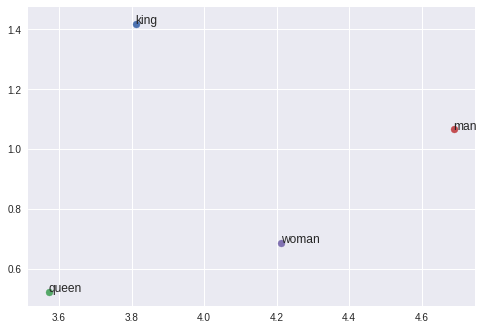

In [22]:
plot_embeddings(words=["king", "queen", "man", "woman"], embeddings=glove, 
                pca_results=pca_results)

In [16]:
# Bias in embeddings
glove.most_similar(positive=['woman', 'doctor'], negative=['man'], topn=5)

NameError: name 'glove' is not defined

# Using Embeddings

There are several different ways to use embeddings. 

1. Use your own trained embeddings (trained on an unsupervised dataset).
2. Use pretrained embeddings (GloVe, word2vec, etc.)
3. Randomly initialized embeddings.

Once you have chosen embeddings, you can choose to freeze them or continue to train them using the supervised data (this could lead to overfitting). In this example, we're going to use GloVe embeddings and freeze them during training. Our task will be to predict an article's category given its title.

## Set up

In [24]:
# Load PyTorch library
!pip3 install torch

In [29]:
import os
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch

In [30]:
# Set Numpy and PyTorch seeds
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
# Creating directories
def create_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [31]:
# Arguments
args = Namespace(
    seed=1234,
    cuda=True,
    shuffle=True,
    data_file="news.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="news",
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    cutoff=25, # token must appear at least <cutoff> times to be in SequenceVocabulary
    num_epochs=5,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    batch_size=64,
    num_filters=100,
    embedding_dim=100,
    hidden_dim=100,
    dropout_p=0.1,
)

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

# Create save dir
create_dirs(args.save_dir)

# Expand filepaths
args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Using CUDA: False


## Data

In [19]:
import re
import urllib

In [20]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/news.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as fp:
    fp.write(html)

In [21]:
# Raw data
df = pd.read_csv(args.data_file, header=0)
df.head()

,category,title
0,Business,Wall St. Bears Claw Back Into the Black (Reuters)
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters)
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,Business,"Oil prices soar to all-time record, posing new..."


In [32]:
# Split by category
by_category = collections.defaultdict(list)
for _, row in df.iterrows():
    by_category[row.category].append(row.to_dict())
for category in by_category:
    print ("{0}: {1}".format(category, len(by_category[category])))

Business: 30000
Sci/Tech: 30000
Sports: 30000
World: 30000


In [33]:
# Create split data
final_list = []
for _, item_list in sorted(by_category.items()):
    if args.shuffle:
        np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_size*n)
    n_val = int(args.val_size*n)
    n_test = int(args.test_size*n)

  # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  

    # Add to final list
    final_list.extend(item_list)

In [34]:
# df with split datasets
split_df = pd.DataFrame(final_list)
split_df["split"].value_counts()

train    84000
test     18000
val      18000
Name: split, dtype: int64

In [35]:
# Preprocessing
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
split_df.title = split_df.title.apply(preprocess_text)
split_df.head()

,category,split,title
0,Business,train,general electric posts higher rd quarter profit
1,Business,train,lilly to eliminate up to us jobs
2,Business,train,s amp p lowers america west outlook to negative
3,Business,train,does rand walk the talk on labor policy ?
4,Business,train,housekeeper advocates for changes


## Vocabulary

In [23]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):

        # Token to index
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        return self.token_to_idx[token]

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

In [25]:
for index, row in df.iterrows():
    print(index, row.category)

0 Business
1 Business
2 Business
3 Business
4 Business
5 Business
6 Business
7 Business
8 Business
9 Business
10 Business
11 Business
12 Business
13 Business
14 Business
15 Business
16 Business
17 Business
18 Business
19 Business
20 Business
21 Business
22 Business
23 Business
24 Business
25 Business
26 Business
27 Business
28 Business
29 Business
30 Business
31 Business
32 Business
33 Business
34 Business
35 Business
36 Business
37 Business
38 Business
39 Business
40 Business
41 Business
42 Business
43 Business
44 Business
45 Business
46 Business
47 Business
48 Business
49 Business
50 Business
51 Business
52 Business
53 Business
54 Business
55 Business
56 Business
57 Business
58 Business
59 Business
60 Business
61 Business
62 Business
63 Business
64 Business
65 Business
66 Business
67 Business
68 Business
69 Business
70 Business
71 Business
72 Business
73 Business
74 Business
75 Business
76 Business
77 Business
78 Sci/Tech
79 Sci/Tech
80 Sci/Tech
81 Sci/Tech
82 Sci/Tech
83 Sci/Tech
84

1038 Sports
1039 Business
1040 Sci/Tech
1041 Sports
1042 Sports
1043 Sports
1044 World
1045 World
1046 World
1047 World
1048 Sci/Tech
1049 Sci/Tech
1050 Sports
1051 Sports
1052 World
1053 Sci/Tech
1054 Sci/Tech
1055 Sci/Tech
1056 World
1057 Sci/Tech
1058 Sports
1059 Sports
1060 Business
1061 Business
1062 Sci/Tech
1063 Sci/Tech
1064 Sci/Tech
1065 Sci/Tech
1066 Sci/Tech
1067 Sports
1068 Sports
1069 World
1070 World
1071 World
1072 Business
1073 Sci/Tech
1074 Sports
1075 World
1076 World
1077 World
1078 World
1079 World
1080 World
1081 Sci/Tech
1082 Sports
1083 World
1084 World
1085 Sci/Tech
1086 Sci/Tech
1087 Sci/Tech
1088 Sports
1089 Sports
1090 Business
1091 Business
1092 Sci/Tech
1093 Sports
1094 World
1095 World
1096 World
1097 Sci/Tech
1098 Sci/Tech
1099 Sci/Tech
1100 Sci/Tech
1101 Sci/Tech
1102 Sci/Tech
1103 Sci/Tech
1104 Sci/Tech
1105 Sci/Tech
1106 Sci/Tech
1107 Sci/Tech
1108 Sci/Tech
1109 Sports
1110 Sports
1111 Sports
1112 Business
1113 World
1114 World
1115 World
1116 Business

2038 Sci/Tech
2039 Sports
2040 Sports
2041 Sports
2042 World
2043 Sci/Tech
2044 Sci/Tech
2045 Sci/Tech
2046 Sci/Tech
2047 World
2048 World
2049 World
2050 World
2051 Business
2052 Business
2053 Business
2054 Business
2055 Sports
2056 Sports
2057 Sports
2058 Sports
2059 World
2060 World
2061 World
2062 Business
2063 Sci/Tech
2064 Sci/Tech
2065 Sports
2066 World
2067 Sci/Tech
2068 Sci/Tech
2069 Business
2070 Business
2071 Sci/Tech
2072 Sci/Tech
2073 Sci/Tech
2074 World
2075 World
2076 Sci/Tech
2077 Sci/Tech
2078 World
2079 Business
2080 Sci/Tech
2081 Sci/Tech
2082 Sci/Tech
2083 Business
2084 Business
2085 Sports
2086 World
2087 Sci/Tech
2088 Sci/Tech
2089 Sci/Tech
2090 Sci/Tech
2091 Sci/Tech
2092 Business
2093 World
2094 Sci/Tech
2095 Sci/Tech
2096 Sports
2097 Sci/Tech
2098 Sci/Tech
2099 Sci/Tech
2100 Sci/Tech
2101 Sports
2102 Sports
2103 World
2104 World
2105 World
2106 World
2107 World
2108 Business
2109 Business
2110 Business
2111 Business
2112 Business
2113 Sci/Tech
2114 Sports
2115 

2876 Business
2877 Sci/Tech
2878 Sci/Tech
2879 Sci/Tech
2880 Sci/Tech
2881 Sports
2882 Sports
2883 World
2884 World
2885 Sports
2886 World
2887 Business
2888 Business
2889 Sci/Tech
2890 Sci/Tech
2891 Sci/Tech
2892 Sci/Tech
2893 Sci/Tech
2894 Business
2895 Business
2896 Business
2897 Sci/Tech
2898 Sci/Tech
2899 Sci/Tech
2900 Sports
2901 Sports
2902 World
2903 World
2904 World
2905 World
2906 Business
2907 Business
2908 Business
2909 Business
2910 Business
2911 Sci/Tech
2912 Sci/Tech
2913 Sports
2914 Sports
2915 Sports
2916 Sports
2917 World
2918 World
2919 World
2920 Sports
2921 Sports
2922 Sci/Tech
2923 Sci/Tech
2924 Sci/Tech
2925 Business
2926 Business
2927 Business
2928 Business
2929 Business
2930 Business
2931 Sports
2932 Business
2933 Business
2934 Business
2935 Business
2936 Sci/Tech
2937 Sports
2938 Sports
2939 World
2940 World
2941 World
2942 World
2943 World
2944 Sports
2945 Sci/Tech
2946 Sci/Tech
2947 Business
2948 Sci/Tech
2949 Sci/Tech
2950 Sci/Tech
2951 Business
2952 Busine

KeyboardInterrupt: 

In [26]:
# Vocabulary instance
category_vocab = Vocabulary()
for index, row in df.iterrows():
    category_vocab.add_token(row.category)
print (category_vocab) # __str__
print (len(category_vocab)) # __len__
index = category_vocab.lookup_token("Business")
print (index)
print (category_vocab.lookup_index(0))
print (category_vocab.lookup_index(1))
print (category_vocab.lookup_index(2))
print (category_vocab.lookup_index(3))

<Vocabulary(size=4)>
4
0
Business
Sci/Tech
Sports
World


## Sequence vocabulary

Next, we're going to create our Vocabulary classes for the article's title, which is a sequence of tokens.

In [27]:
from collections import Counter
import string

In [17]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self.mask_token = mask_token
        self.unk_token = unk_token
        self.begin_seq_token = begin_seq_token
        self.end_seq_token = end_seq_token

        self.mask_index = self.add_token(self.mask_token)
        self.unk_index = self.add_token(self.unk_token)
        self.begin_seq_index = self.add_token(self.begin_seq_token)
        self.end_seq_index = self.add_token(self.end_seq_token)
        
        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self.unk_token,
                         'mask_token': self.mask_token,
                         'begin_seq_token': self.begin_seq_token,
                         'end_seq_token': self.end_seq_token})
        return contents

    def lookup_token(self, token):
        return self.token_to_idx.get(token, self.unk_index)
    
    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the SequenceVocabulary" % index)
        return self.idx_to_token[index]
    
    def __str__(self):
        return "<SequenceVocabulary(size=%d)>" % len(self.token_to_idx)

    def __len__(self):
        return len(self.token_to_idx)


In [18]:
# Get word counts
word_counts = Counter()
for title in split_df.title:
    for token in title.split(" "):
        if token not in string.punctuation:
            word_counts[token] += 1

# Create SequenceVocabulary instance
title_vocab = SequenceVocabulary()
for word, word_count in word_counts.items():
    if word_count >= args.cutoff:
        title_vocab.add_token(word)
print (title_vocab) # __str__
print (len(title_vocab)) # __len__
index = title_vocab.lookup_token("general")
print (index)
print (title_vocab.lookup_index(index))

<SequenceVocabulary(size=4400)>
4400
4
general


## Vectorizer

In [19]:
class NewsVectorizer(object):
    def __init__(self, title_vocab, category_vocab):
        self.title_vocab = title_vocab
        self.category_vocab = category_vocab

    def vectorize(self, title):
        indices = [self.title_vocab.lookup_token(token) for token in title.split(" ")]
        indices = [self.title_vocab.begin_seq_index] + indices + \
            [self.title_vocab.end_seq_index]
        
        # Create vector
        title_length = len(indices)
        vector = np.zeros(title_length, dtype=np.int64)
        vector[:len(indices)] = indices

        return vector
    
    def unvectorize(self, vector):
        tokens = [self.title_vocab.lookup_index(index) for index in vector]
        title = " ".join(token for token in tokens)
        return title

    @classmethod
    def from_dataframe(cls, df, cutoff):
        
        # Create class vocab
        category_vocab = Vocabulary()        
        for category in sorted(set(df.category)):
            category_vocab.add_token(category)

        # Get word counts
        word_counts = Counter()
        for title in df.title:
            for token in title.split(" "):
                word_counts[token] += 1
        
        # Create title vocab
        title_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                title_vocab.add_token(word)
        
        return cls(title_vocab, category_vocab)

    @classmethod
    def from_serializable(cls, contents):
        title_vocab = SequenceVocabulary.from_serializable(contents['title_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['category_vocab'])
        return cls(title_vocab=title_vocab, category_vocab=category_vocab)
    
    def to_serializable(self):
        return {'title_vocab': self.title_vocab.to_serializable(),
                'category_vocab': self.category_vocab.to_serializable()}

In [20]:
# Vectorizer instance
vectorizer = NewsVectorizer.from_dataframe(split_df, cutoff=args.cutoff)
print (vectorizer.title_vocab)
print (vectorizer.category_vocab)
vectorized_title = vectorizer.vectorize(preprocess_text(
    "Roger Federer wins the Wimbledon tennis tournament."))
print (np.shape(vectorized_title))
print (vectorized_title)
print (vectorizer.unvectorize(vectorized_title))

<SequenceVocabulary(size=4405)>
<Vocabulary(size=4)>
(11,)
[   2    1 4152 1232   25    1 2393 4077   39   31    3]
<BEGIN> <UNK> federer wins the <UNK> tennis tournament .  <END>


## Dataset

In [21]:
from torch.utils.data import Dataset, DataLoader

In [22]:
class NewsDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer
        
        # Max title length
        get_length = lambda title: len(title.split(" "))
        self.max_seq_length = max(map(get_length, df.title)) + 2 # (<BEGIN> + <END>)

        # Data splits
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {'train': (self.train_df, self.train_size), 
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights (for imbalances)
        class_counts = df.category.value_counts().to_dict()
        def sort_key(item):
            return self.vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, df, cutoff):
        train_df = df[df.split=='train']
        return cls(df, NewsVectorizer.from_dataframe(train_df, cutoff))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, df, vectorizer_filepath):
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NewsVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        title_vector = self.vectorizer.vectorize(row.title)
        category_index = self.vectorizer.category_vocab.lookup_token(row.category)
        return {'title': title_vector, 'category': category_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, collate_fn, shuffle=True, 
                         drop_last=False, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size,
                                collate_fn=collate_fn, shuffle=shuffle, 
                                drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [23]:
# Dataset instance
dataset = NewsDataset.load_dataset_and_make_vectorizer(df=split_df, 
                                                       cutoff=args.cutoff)
print (dataset) # __str__
title_vector = dataset[5]['title'] # __getitem__
print (title_vector)
print (dataset.vectorizer.unvectorize(title_vector))
print (dataset.class_weights)

<Dataset(split=train, size=84000)
[ 2 32 33 10 34 13  3]
<BEGIN> software firm to cut jobs <END>
tensor([3.3333e-05, 3.3333e-05, 3.3333e-05, 3.3333e-05])


## Model

input → embedding → conv → FC 

We will be using 1d conv operations ([nn.Conv1D](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv1d)) even though our inputs are words because we are not representing them at a character level. The inputs are of shape $\in \mathbb{R}^{NXSXE}$
* where:
    * N = batchsize
    * S = max sentence length 
    * E = embedding dim at a word level

In [24]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
class NewsModel(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, num_input_channels, 
                 num_channels, hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, freeze_embeddings=False,
                 padding_idx=0):
        super(NewsModel, self).__init__()
        
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                          num_embeddings=num_embeddings,
                                          padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                           num_embeddings=num_embeddings,
                                           padding_idx=padding_idx,
                                           _weight=pretrained_embeddings)
        
        # Conv weights
        self.conv = nn.ModuleList([nn.Conv1d(num_input_channels, num_channels, 
                                             kernel_size=f) for f in [2,3,4]])
     
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_channels*3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False

    def forward(self, x_in, channel_first=False, apply_softmax=False):
        
        # Embed
        x_in = self.embeddings(x_in)

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        if not channel_first:
            x_in = x_in.transpose(1, 2)
            
        # Conv outputs
        z1 = self.conv[0](x_in)
        z1 = F.max_pool1d(z1, z1.size(2)).squeeze(2)
        z2 = self.conv[1](x_in)
        z2 = F.max_pool1d(z2, z2.size(2)).squeeze(2)
        z3 = self.conv[2](x_in)
        z3 = F.max_pool1d(z3, z3.size(2)).squeeze(2)
        
        # Concat conv outputs
        z = torch.cat([z1, z2, z3], 1)

        # FC layers
        z = self.dropout(z)
        z = self.fc1(z)
        y_pred = self.fc2(z)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

## Training

In [26]:
import torch.optim as optim

In [27]:
class Trainer(object):
    def __init__(self, dataset, model, model_state_file, save_dir, device, shuffle, 
               num_epochs, batch_size, learning_rate, early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.model = model.to(device)
        self.save_dir = save_dir
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'done_training': False,
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_state_file}
    
    def update_train_state(self):

        # Verbose
        print ("[EPOCH]: {0} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
          self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1], 
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1]))

        # Save one model at least
        if self.train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), self.train_state['model_filename'])
            self.train_state['stop_early'] = False

        # Save model if performance improved
        elif self.train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = self.train_state['val_loss'][-2:]

            # If loss worsened
            if loss_t >= self.train_state['early_stopping_best_val']:
                # Update step
                self.train_state['early_stopping_step'] += 1

            # Loss decreased
            else:
                # Save the best model
                if loss_t < self.train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), self.train_state['model_filename'])

                # Reset early stopping step
                self.train_state['early_stopping_step'] = 0

            # Stop early ?
            self.train_state['stop_early'] = self.train_state['early_stopping_step'] \
              >= self.train_state['early_stopping_criteria']
        return self.train_state
  
    def compute_accuracy(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        n_correct = torch.eq(y_pred_indices, y_target).sum().item()
        return n_correct / len(y_pred_indices) * 100
    
    def pad_seq(self, seq, length):
        vector = np.zeros(length, dtype=np.int64)
        vector[:len(seq)] = seq
        vector[len(seq):] = self.dataset.vectorizer.title_vocab.mask_index
        return vector
    
    def collate_fn(self, batch):
        
        # Make a deep copy
        batch_copy = copy.deepcopy(batch)
        processed_batch = {"title": [], "category": []}
        
        # Get max sequence length
        max_seq_len = max([len(sample["title"]) for sample in batch_copy])
        
        # Pad
        for i, sample in enumerate(batch_copy):
            seq = sample["title"]
            category = sample["category"]
            padded_seq = self.pad_seq(seq, max_seq_len)
            processed_batch["title"].append(padded_seq)
            processed_batch["category"].append(category)
            
        # Convert to appropriate tensor types
        processed_batch["title"] = torch.LongTensor(
            processed_batch["title"])
        processed_batch["category"] = torch.LongTensor(
            processed_batch["category"])
        
        return processed_batch    
  
    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # Iterate over train dataset

            # initialize batch generator, set loss and acc to 0, set train mode on
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn, 
                shuffle=self.shuffle, device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # zero the gradients
                self.optimizer.zero_grad()

                # compute the output
                y_pred = self.model(batch_dict['title'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute gradients using loss
                loss.backward()

                # use optimizer to take a gradient step
                self.optimizer.step()
                
                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # initialize batch generator, set loss and acc to 0; set eval mode on
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn, 
                shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred =  self.model(batch_dict['title'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = self.update_train_state()
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        # initialize batch generator, set loss and acc to 0; set eval mode on
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, collate_fn=self.collate_fn, 
                shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  self.model(batch_dict['title'])

            # compute the loss
            loss = self.loss_func(y_pred, batch_dict['category'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
    
    def plot_performance(self):
        # Figure size
        plt.figure(figsize=(15,5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(trainer.train_state["train_loss"], label="train")
        plt.plot(trainer.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(trainer.train_state["train_acc"], label="train")
        plt.plot(trainer.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
        plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # Show plots
        plt.show()
    
    def save_train_state(self):
        self.train_state["done_training"] = True
        with open(os.path.join(self.save_dir, "train_state.json"), "w") as fp:
            json.dump(self.train_state, fp)

In [28]:
# Initialization
dataset = NewsDataset.load_dataset_and_make_vectorizer(df=split_df, 
                                                       cutoff=args.cutoff)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_embeddings=len(vectorizer.title_vocab), 
                  num_input_channels=args.embedding_dim, 
                  num_channels=args.num_filters, hidden_dim=args.hidden_dim, 
                  num_classes=len(vectorizer.category_vocab), 
                  dropout_p=args.dropout_p, pretrained_embeddings=None, 
                  padding_idx=vectorizer.title_vocab.mask_index)
print (model.named_modules)

<bound method Module.named_modules of NewsModel(
  (embeddings): Embedding(3407, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [31]:
import copy

In [32]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 0 | [LR]: 0.001 | [TRAIN LOSS]: 0.79 | [TRAIN ACC]: 69.0% | [VAL LOSS]: 0.58 | [VAL ACC]: 78.3%
[EPOCH]: 1 | [LR]: 0.001 | [TRAIN LOSS]: 0.51 | [TRAIN ACC]: 81.7% | [VAL LOSS]: 0.50 | [VAL ACC]: 81.9%
[EPOCH]: 2 | [LR]: 0.001 | [TRAIN LOSS]: 0.42 | [TRAIN ACC]: 84.8% | [VAL LOSS]: 0.49 | [VAL ACC]: 82.3%


KeyboardInterrupt: 

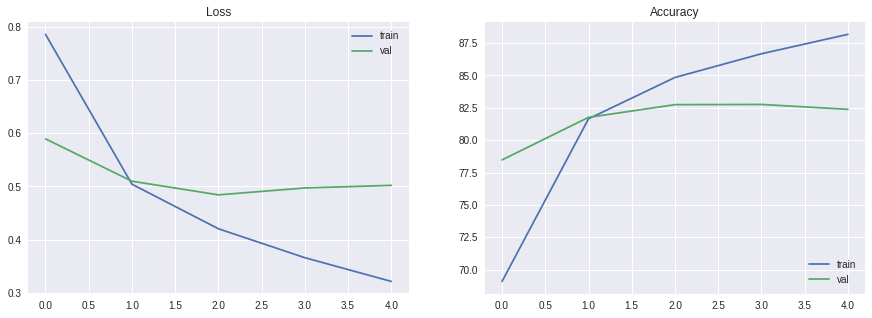

In [54]:
# Plot performance
trainer.plot_performance()

In [55]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 0.50
Test Accuracy: 82.8%


In [0]:
# Save all results
trainer.save_train_state()

## Using GloVe embeddings

We just used some randomly initialized embeddings and we were able to receive decent performance. Keep in mind that this may not always be the case and we may overfit on other datasets with this approach. We're now going to use pretrained GloVe embeddings to initialize our embeddings. We will train our model on the supervised task and assess the performance by first freezing these embeddings (so they don't change during training) and then not freezing them and allowing them to be trained. 

```python
pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
self.embeddings = nn.Embedding(embedding_dim=embedding_dim, 
                               num_embeddings=num_embeddings, 
                               padding_idx=padding_idx, 
                               _weight=pretrained_embeddings)
```

In [0]:
def load_glove_embeddings(embeddings_file):
    word_to_idx = {}
    embeddings = []

    with open(embeddings_file, "r") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ")
            word = line[0]
            word_to_idx[word] = index
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)

    return word_to_idx, np.stack(embeddings)

def make_embeddings_matrix(words):
    word_to_idx, glove_embeddings = load_glove_embeddings(embeddings_file)
    embedding_dim = glove_embeddings.shape[1]
    embeddings = np.zeros((len(words), embedding_dim))
    for i, word in enumerate(words):
        if word in word_to_idx:
            embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.zeros(1, embedding_dim)
            nn.init.xavier_uniform_(embedding_i)
            embeddings[i, :] = embedding_i

    return embeddings

In [0]:
args.use_glove_embeddings = True

In [59]:
# Initialization
dataset = NewsDataset.load_dataset_and_make_vectorizer(df=split_df, 
                                                       cutoff=args.cutoff)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer

# Create embeddings
embeddings = None
if args.use_glove_embeddings:
    embeddings_file = 'glove.6B.{0}d.txt'.format(args.embedding_dim)
    words = vectorizer.title_vocab.token_to_idx.keys()
    embeddings = make_embeddings_matrix(words=words)
    print ("<Embeddings(words={0}, dim={1})>".format(
        np.shape(embeddings)[0], np.shape(embeddings)[1]))

<Embeddings(words=3407, dim=100)>


In [60]:
# Initialize model
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_embeddings=len(vectorizer.title_vocab), 
                  num_input_channels=args.embedding_dim, 
                  num_channels=args.num_filters, hidden_dim=args.hidden_dim, 
                  num_classes=len(vectorizer.category_vocab), 
                  dropout_p=args.dropout_p, pretrained_embeddings=embeddings, 
                  padding_idx=vectorizer.title_vocab.mask_index)
print (model.named_modules)

<bound method Module.named_modules of NewsModel(
  (embeddings): Embedding(3407, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [61]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 0 | [LR]: 0.001 | [TRAIN LOSS]: 0.50 | [TRAIN ACC]: 81.9% | [VAL LOSS]: 0.44 | [VAL ACC]: 84.1%
[EPOCH]: 1 | [LR]: 0.001 | [TRAIN LOSS]: 0.41 | [TRAIN ACC]: 85.1% | [VAL LOSS]: 0.46 | [VAL ACC]: 83.9%
[EPOCH]: 2 | [LR]: 0.001 | [TRAIN LOSS]: 0.37 | [TRAIN ACC]: 86.5% | [VAL LOSS]: 0.44 | [VAL ACC]: 84.4%
[EPOCH]: 3 | [LR]: 0.001 | [TRAIN LOSS]: 0.33 | [TRAIN ACC]: 87.9% | [VAL LOSS]: 0.45 | [VAL ACC]: 83.8%
[EPOCH]: 4 | [LR]: 0.001 | [TRAIN LOSS]: 0.29 | [TRAIN ACC]: 89.3% | [VAL LOSS]: 0.46 | [VAL ACC]: 84.1%


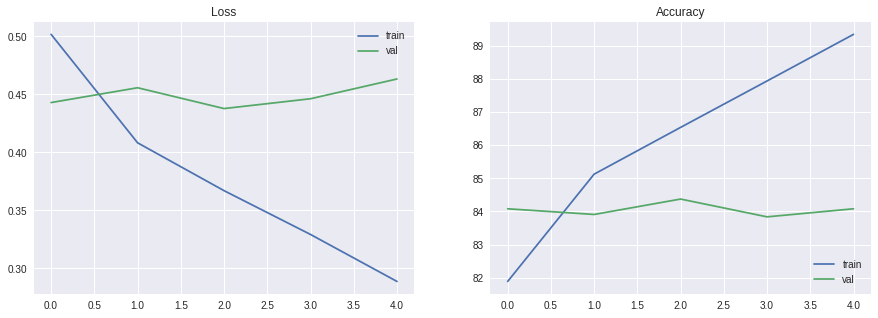

In [62]:
# Plot performance
trainer.plot_performance()

In [63]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 0.46
Test Accuracy: 84.0%


In [0]:
# Save all results
trainer.save_train_state()

## Freeze embeddings

Now we're going to freeze our GloVe embeddings and train on the supervised task. The only modification in the model is to turn on `freeze_embeddings`:

```python
if freeze_embeddings:
    self.embeddings.weight.requires_grad = False
```

In [0]:
args.freeze_embeddings = True

In [66]:
# Initialize model
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_embeddings=len(vectorizer.title_vocab), 
                  num_input_channels=args.embedding_dim, 
                  num_channels=args.num_filters, hidden_dim=args.hidden_dim, 
                  num_classes=len(vectorizer.category_vocab), 
                  dropout_p=args.dropout_p, pretrained_embeddings=embeddings,
                  freeze_embeddings=args.freeze_embeddings,
                  padding_idx=vectorizer.title_vocab.mask_index)
print (model.named_modules)

<bound method Module.named_modules of NewsModel(
  (embeddings): Embedding(3407, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [67]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 0 | [LR]: 0.001 | [TRAIN LOSS]: 0.53 | [TRAIN ACC]: 80.7% | [VAL LOSS]: 0.48 | [VAL ACC]: 82.7%
[EPOCH]: 1 | [LR]: 0.001 | [TRAIN LOSS]: 0.45 | [TRAIN ACC]: 83.6% | [VAL LOSS]: 0.46 | [VAL ACC]: 83.4%
[EPOCH]: 2 | [LR]: 0.001 | [TRAIN LOSS]: 0.42 | [TRAIN ACC]: 85.0% | [VAL LOSS]: 0.46 | [VAL ACC]: 83.8%
[EPOCH]: 3 | [LR]: 0.001 | [TRAIN LOSS]: 0.39 | [TRAIN ACC]: 85.9% | [VAL LOSS]: 0.46 | [VAL ACC]: 83.6%
[EPOCH]: 4 | [LR]: 0.001 | [TRAIN LOSS]: 0.36 | [TRAIN ACC]: 87.0% | [VAL LOSS]: 0.46 | [VAL ACC]: 83.7%


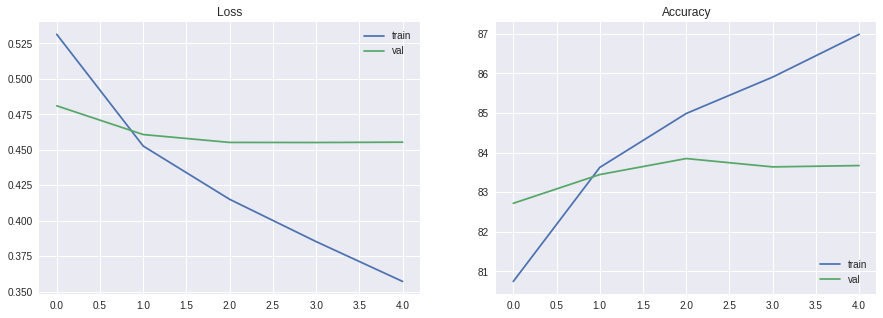

In [68]:
# Plot performance
trainer.plot_performance()

In [69]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 0.46
Test Accuracy: 83.9%


In [0]:
# Save all results
trainer.save_train_state()

So you can see that using GloVe embeddings but not freezing them resulted in the best results on the test dataset. Different tasks will yield different results so you need to choose whether or not to freeze your embeddings based on empirical results.

# TODO

* when to use skip-gram/CBOW
    * According to Mikolov:
        
        Skip-gram: works well with small amount of the training data, represents well even rare words or phrases.
        
        CBOW: several times faster to train than the skip-gram, slightly better accuracy for the frequent words
* Loading word2vec
* interpretable conv filters since we apply it on words here
* [contextualized word embeddings](https://arxiv.org/abs/1607.00578)